# Introduction

## Standard imports

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import time
np.random.seed(int(time.time()))

## Specific imports

In [3]:
from noise_parameters import NOISE
from generate_timeseries import Timeseries, make_params
from noise_properties_plotting import PlotTimeseriesComparison #, PlotNoiseColorComparison, PiecewiseNormalize
#from scipy.optimize import curve_fit
#from neutrality_analysis import KullbackLeibler_neutrality
#from neutral_covariance_test import neutral_covariance_test
from scipy import stats
from noise_analysis import noise_color
from matplotlib.colors import Normalize

#import os

## Settings figures

In [4]:
from elife_settings import set_elife_settings, ELIFE

set_elife_settings()

In [5]:
def ratio(x):
    return np.array([x1/x2 for x1, x2 in zip(x[:-1], x[1:]) 
                     if x1 != 0 and x2 != 0 and ~np.isnan(x1) and ~np.isnan(x2)])
    
def fit_ratio(x):
    # Return the parameters of the fit and the goodness of fit values
    x = ratio(x)
    x = x[np.isfinite(x)]

    if len(x) > 10:
        a, b, c = stats.lognorm.fit(x,floc=0)
        stat, pval = stats.kstest(x, 'lognorm', args=((a,b,c)))
    else:
        return np.nan, np.nan, np.nan, np.nan, np.nan
    return a, b, c, stat, pval

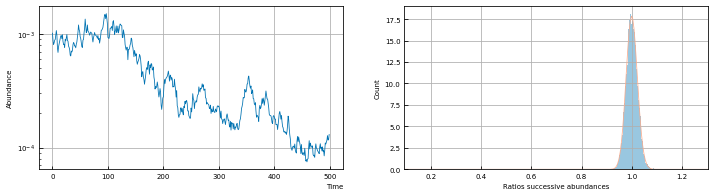

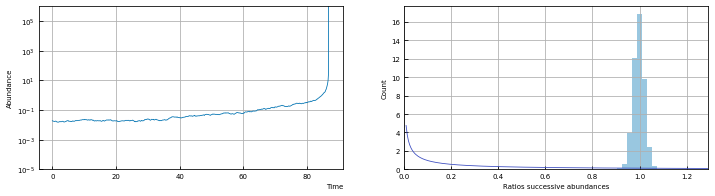

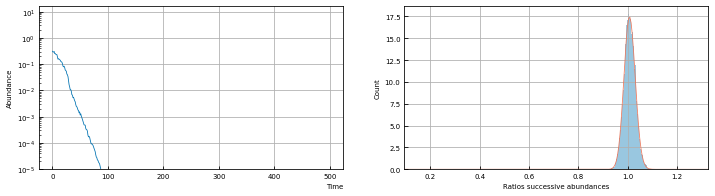

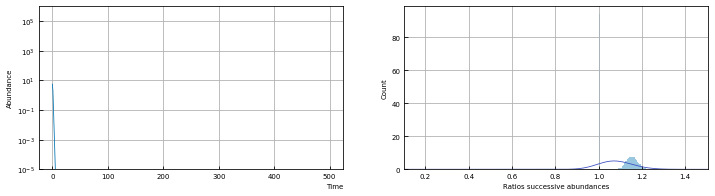

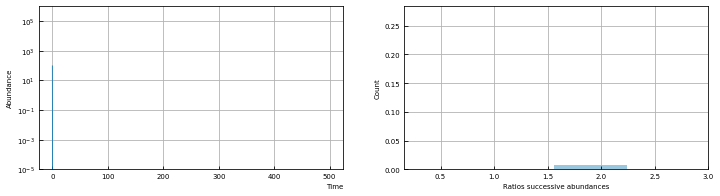

In [13]:
N = 5

ss = np.logspace(-3, 2, N)
df = pd.DataFrame({'ss' : ss})

df['a'] = np.zeros(len(ss))
df['b'] = np.zeros(len(ss))
df['c'] = np.zeros(len(ss))

for row in df.index:
    steadystate = np.array([df.loc[row, 'ss']]).reshape([1,1])
    
    params = make_params(steadystate, selfint=-0.5, noise=0.1)
    
    ts = Timeseries(params, noise_implementation = NOISE.LANGEVIN_LINEAR, 
                            dt = 0.01, tskip=4, T=500.0, seed=int(time.time())).timeseries

    x = ts['species_1'].values
    x_transf = ratio(x)
    a, b, c, stat, pval = fit_ratio(x)
    
    for key, value in zip(['a', 'b', 'c', 'stat', 'pval'],[a, b, c, stat, pval]):
        df.loc[row, key] = value
    
    fig = plt.figure(figsize=(12,3))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    PlotTimeseriesComparison([ts], composition=['ts'], fig=ax1)

    x = ts['species_1'].values

    x_fit = np.linspace(0.01,5,1000)
    pdf_fitted = stats.lognorm.pdf(x_fit,a,b,c) #Gives the PDF
        
    ax2.hist(x_transf[np.isfinite(x_transf)], alpha=0.4, density=True, bins = 50)
    cmap = plt.cm.get_cmap('coolwarm')
    c = cmap(pval)
    ax2.plot(x_fit, pdf_fitted, c=c)

    ax2.set_xlim([(0.1*min(x_transf)),min(1.2*max(x_transf), 3)])
    #ax2.legend()
    ax2.set_ylabel('Count')
    ax2.set_xlabel('Ratios successive abundances')
    ax2.grid()
    plt.show()

In [8]:
new = False

if new:
    ss = np.logspace(-3, 2, 50)

    df = pd.DataFrame({'ss' : ss})

    sigmas = [0.5, 0.7, 0.8, 1.0] #0.01, 0.1, 0.2, 0.25, 0.3]

    for sigma in sigmas:
        df['sigma_%.2f_width_mean' % sigma] = np.zeros(len(ss))
        df['sigma_%.2f_width_std' % sigma] = np.zeros(len(ss))
        df['sigma_%.2f_pval' % sigma] = np.zeros(len(ss))

        for row in df.index:
            if row % 10 == 0:
                print(row)

            params = {}

            N = 50

            steadystate = np.repeat(df.loc[row, 'ss'], N).reshape([N,1])

            # no interaction
            #omega = np.zeros([N,N]); np.fill_diagonal(omega, -1)
            omega = np.random.normal(0,0.15,[N,N]); np.fill_diagonal(omega, -1)

            params['interaction_matrix'] = omega

            # no immigration
            params['immigration_rate'] = np.zeros([N, 1])

            # different growthrates determined by the steady state
            params['growth_rate'] = - (omega).dot(steadystate)

            params['noise_linear'] = sigma

            multi_a = np.zeros(10)
            multi_pval = np.zeros(10)

            params['initial_condition'] = np.copy(steadystate) * np.random.normal(1,0.1,steadystate.shape)


            ts = Timeseries(params, noise_implementation = NOISE.LANGEVIN_LINEAR, 
                                dt = 0.01, tskip=4, T=500.0, seed=int(time.time())).timeseries

            multi_a = np.zeros(N)
            multi_pval = np.zeros(N)

            for i in range(N):
                x = ts['species_%d' % (i+1)].values

                x_transf = ratio(x)

                a, b, c, stat, pval = fit_ratio(x)

                multi_a[i] = a
                multi_pval[i] = pval

            df.loc[row, 'sigma_%.2f_width_mean' % sigma] = np.nanmean(multi_a)
            df.loc[row, 'sigma_%.2f_width_std' % sigma] = np.nanstd(multi_a)
            df.loc[row, 'sigma_%.2f_pval' % sigma] = np.nanmean(multi_pval)
    df.to_csv('results/width_ratios/width_lognormal_fit_1_interaction0.15_b.csv')
else:
    df = pd.read_csv('results/width_ratios/width_lognormal_fit_1_interaction0.15_b.csv')

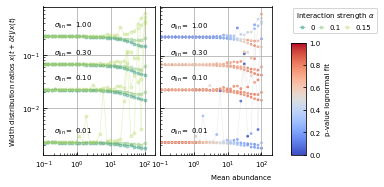

In [9]:
sigmas = [0.01, 0.1, 0.3, 1.0]

cmap = plt.cm.get_cmap('coolwarm') #viridis')

norm = Normalize(vmin=0, vmax=0.21, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap='summer')

fig = plt.figure(figsize=(ELIFE.TEXTWIDTH,2.5))

gs = gridspec.GridSpec(1,2, width_ratios=[5,5], right=0.7, top=0.95, wspace=0.05)
gs2 = gridspec.GridSpec(2,2, height_ratios=[1,5], width_ratios = [1,4], 
                        left=0.75, right=0.95, top=0.95)

ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax_legend = fig.add_subplot(gs2[0:2])
ax_cbar = fig.add_subplot(gs2[2])

ax.set_xscale('log')
ax.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')

path = 'results/width_ratios/'
df1 = pd.read_csv(path + 'width_lognormal_fit_1.csv')
df2 = pd.read_csv(path + 'width_lognormal_fit_1_interaction0.05.csv')
df3 = pd.read_csv(path + 'width_lognormal_fit_1_interaction0.1.csv')
df4 = pd.read_csv(path + 'width_lognormal_fit_1_interaction0.15.csv')

#for i, df, alpha in zip(range(4), [df1, df2, df3, df4], [0, 0.05, 0.1, 0.15]):
for i, df, alpha in zip(range(3), [df1, df3, df4], [0, 0.1, 0.15]):
    for j, sigma in enumerate(sigmas):
        w = df['sigma_%.2f_width_mean' % sigma].values
        pval = df['sigma_%.2f_pval' % sigma].values
        ss = df['ss'].values
        
        col = np.array(mapper.to_rgba(alpha))
                
        #with np.errstate(divide='ignore'):
        ax.plot(ss, w, c=col, alpha=0.3, marker='o', markersize=3, label=alpha if j==0 else "")
        ax2.plot(ss, w, c='lightgrey', alpha=0.3) #, label=alpha if j==0 else "")
        s_ax2 = ax2.scatter(ss, w, s=3, c = pval, cmap=cmap, vmin=0, vmax=1)
        
        x = 2e-1 #ss.values[0]
        y = w[0]
        
        if i == 0:
            ax.annotate(r"$\sigma_\mathregular{lin} =$ %.2f" % sigma, xy=(x, y), xytext=(x, 1.5*y))
            ax2.annotate(r"$\sigma_\mathregular{lin} =$ %.2f" % sigma, xy=(x, y), xytext=(x, 1.5*y))

handles, labels = ax.get_legend_handles_labels()
ax_legend.legend(handles, labels, title='Interaction ' + r'strength $\alpha$', 
                 loc=2, ncol=3, columnspacing=0.5)
ax_legend.axis('off')

cbar = plt.colorbar(s_ax2, cax=ax_cbar)
cbar.set_label('p-value lognormal fit')

ax.set_xscale('log')
ax.set_ylabel('Width distribution ratios $x(t+\delta t) / x(t)$')
ax.set_xlim([1e-1,2e2])
#plt.ylim([-0.01,0.15])
ax.set_yscale('log')
ax.grid()

ax2.tick_params(axis='both', left=True, labelleft=False)
ax2.set_xscale('log')
ax2.set_xlabel(r'Mean abundance', ha='right', x=1)
#ax2.set_ylabel('Scale lognormal fit')
ax2.set_xlim([1e-1,2e2])
#plt.ylim([-0.01,0.15])
ax2.set_yscale('log')
ax2.grid()

plt.show()

In [10]:
new = False

if new:
    N = 50

    def find_ss_selfint(x):
        amplitude = 2.10E+00 
        x0 = 2.87E+00
        k = 1.14E+00
        offset = -1.77E+00

        return 10**( -1/x0 * np.log(amplitude/(x-offset) - 1) + k)

    # stool A
    f = '../../Data/Faust/25_timeseries/25_timeseries.txt'

    x = np.loadtxt(f).T #pd.read_csv(f, na_values='NAN', delimiter='\t', header=None)

    x = x[150:,:] # do not consider the traveling

    experimental_abundance = np.sort(x[0,:])[::-1]

    experimental_noise_color = noise_color(x.T)


    ss = experimental_abundance[:N]

    sigmas = [0.01, 0.1, 1.0, 2.0] #0.01, 0.1, 0.2, 0.25, 0.3]
    interaction = 0.03

    params = {}

    steadystate = (experimental_abundance[:N]).reshape([N, 1])

    selfints = -find_ss_selfint(experimental_noise_color['slope_linear'].values[:N]) / steadystate.flatten()

    df = pd.DataFrame({'ss' : ss, 'selfints':-selfints})


    # no immigration
    params['immigration_rate'] = np.zeros([N, 1])

    params['initial_condition'] = np.copy(steadystate) * np.random.normal(1,0.1,steadystate.shape)

    for sigma in sigmas:    
        params['noise'] = sigma

        params['noise_linear'] = 0
        params['noise_sqrt'] = 0

        for repeat in range(20):
            # interaction
            if interaction == 0:
                omega = np.zeros([N,N])
            else:
                omega = np.random.normal(0,interaction, [N, N]); 
                omega *=  np.random.choice([0,1], omega.shape, p=[0.9, 0.1])
            np.fill_diagonal(omega, selfints)

            params['interaction_matrix'] = omega

            # different growthrates determined by the steady state
            params['growth_rate'] = - (omega).dot(steadystate)

            ts = Timeseries(params, noise_implementation = NOISE.LANGEVIN_LINEAR, 
                dt = 0.01, tskip=19, T=50.0, seed=int(time.time())).timeseries

            PlotTimeseriesComparison([ts], composition=['ts'])
            plt.show()

            multi_a = np.zeros(N)
            multi_pval = np.zeros(N)

            for i in range(N):
                x = ts['species_%d' % (i+1)].values

                x_transf = ratio(x)

                a, b, c, stat, pval = fit_ratio(x)

                multi_a[i] = a
                multi_pval[i] = pval

            df['sigma_%.2f_width_mean_%d' % (sigma, repeat)] = multi_a
            df['sigma_%.2f_pval_%d' % (sigma, repeat)] = multi_pval

    #df.to_csv('results/width_ratios/width_lognormal_fit_experimental_interaction2.csv')
else:
    df = pd.read_csv('results/width_ratios/width_lognormal_fit_experimental_interaction2.csv')

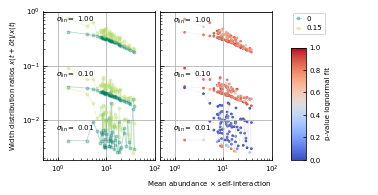

In [79]:
sigmas = [0.01, 0.1, 1.0]

cmap = plt.cm.get_cmap('coolwarm') #viridis')

norm = Normalize(vmin=0, vmax=0.21, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap='summer')

fig = plt.figure(figsize=(ELIFE.TEXTWIDTH,2.5))

gs = gridspec.GridSpec(1,2, width_ratios=[5,5], right=0.7, top=0.95, wspace=0.05)
gs2 = gridspec.GridSpec(2,2, height_ratios=[1,5], width_ratios = [1,4], 
                        left=0.75, right=0.95, top=0.95)

ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax_legend = fig.add_subplot(gs2[0:2])
ax_cbar = fig.add_subplot(gs2[2])

ax.set_xscale('log')
ax.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')

dfs = [pd.read_csv('results/width_ratios/width_lognormal_fit_experimental.csv'),
    pd.read_csv('results/width_ratios/width_lognormal_fit_experimental_interaction2.csv')]

for i, df, alpha, label in zip(range(2), dfs, [0, 0.15], ['No interaction', 'With interaction']):
    for j, sigma in enumerate(sigmas):
        w = df[['sigma_%.2f_width_mean_%d' % (sigma, d) for d in range(20)]].median(axis=1).values
        pval = df[['sigma_%.2f_pval_%d' % (sigma, d) for d in range(20)]].median(axis=1).values
        ss = df['ss'].values
        si = df['selfints'].values

        x = ss * si

        p = x.argsort()

        x = x[p]
        w = w[p]
        pval = pval[p]
        ss = ss[p]
        si = si[p]

        col = mapper.to_rgba(alpha)

        ax.plot(x, w, c=col, alpha=0.3, marker='o', markersize=3, label=alpha if j==0 else "")
        ax2.plot(x, w, c='lightgrey', alpha=0.3) #, label=alpha if j==0 else "")
        s_ax2 = ax2.scatter(x, w, s=3, c = pval, cmap=cmap, vmin=0, vmax=1)
                        #c=col, label=alpha if j==0 else "")
        x = 9e-1 #ss.values[0]
        y = w[0]

        if i == 0:
            ax.annotate(r"$\sigma_\mathregular{lin} =$ %.2f" % sigma, xy=(x, y), xytext=(x, 1.5*y))
            ax2.annotate(r"$\sigma_\mathregular{lin} =$ %.2f" % sigma, xy=(x, y), xytext=(x, 1.5*y))

handles, labels = ax.get_legend_handles_labels()
ax_legend.legend(handles, labels, loc=2)
ax_legend.axis('off')

cbar = plt.colorbar(s_ax2, cax=ax_cbar)
cbar.set_label('p-value lognormal fit')

ax.set_xscale('log')
ax.set_ylabel('Width distribution ratios $x(t + \delta t) / x(t)$')
ax.set_xlim([5e-1,1e2])
#plt.ylim([-0.01,0.15])
ax.set_yscale('log')
ax.grid()

ax2.tick_params(axis='both', left=True, labelleft=False)
ax2.set_xscale('log')
ax2.set_xlabel(r'Mean abundance $\times$ self-interaction', ha='right', x=1)
#ax2.set_ylabel('Scale lognormal fit')
ax2.set_xlim([5e-1,1e2])
#plt.ylim([-0.01,0.15])
ax2.set_yscale('log')
ax2.grid()

plt.show()

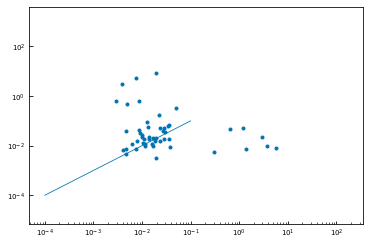

In [80]:
plt.xscale('log')
plt.yscale('log')
plt.scatter(df['sigma_0.01_width_mean_0'], df['sigma_0.01_width_mean_2'])
plt.plot([1e-4,1e-1], [1e-4,1e-1])
plt.show()